In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display

## Which Novel Do I Belong To?

#### In this challenge, you are tasked with training a machine learning model that classifies a given line of text as belonging to one of the following 12 novels:
0. alice_in_wonderland
1. dracula
2. dubliners
3. great_expectations
4. hard_times
5. huckleberry_finn
6. les_miserable
7. moby_dick
8. oliver_twist
9. peter_pan
10. tale_of_two_cities
11. tom_sawyer

#### You are provided three text files, we have applied an encoding to the text, but it is done such that each character has a deterministic mapping. Each line in `xtrain.txt` corresponds to a label in `ytrain.txt`.
- xtrain.txt
- ytrain.txt
- xtest.txt.

#### Example

        line:
        satwamuluhqgulamlrmvezuhqvkrpmletwulcitwskuhlemvtwamuluhiwiwenuhlrvimvqvkruh
        ulenamuluhqgqvtwvimviwuhtwamuluhulqvkrenamcitwuhvipmpmqvuhskiwkrpmdfuhlrvimv
        skvikrpmqvuhskmvgzenleuhqvmvamuluhulenamuluhqvletwtwvipmpmgzleenamuhtwamuluh
        twletwdfuhiwkrxeleentwxeuhpmqvuhtwiwmvamdfuhpkeztwamuluhvimvuhqvtwmkpmpmlelr
        uhgztwtwskuhtwlrkrpmlruhpmuluhqvenuhtwyplepmxeuhenuhamypkrqvuhamulmvdfuhqvsk
        entwamletwlrlrpmiwuhtwamul
        label: 7

## Dataset

In [2]:
df_X = pd.read_csv('./data/Xtrain.txt', header=None)
df_X.columns = ['Text']

df_y = pd.read_csv('./data/ytrain.txt', header=None)
df_y.columns = ['Label']

df = df_X.join(df_y)
df.head()

,Text,Label
0,satwamuluhqgulamlrmvezuhqvkrpmletwulcitwskuhle...,7
1,twmkiwpmqvtwleuhsaiwsktwmvlelekramuhqvkruhtwsk...,3
2,vidfpmskuhvilepmuluhtwtvuhulsovienamqvuhskiwmv...,8
3,raskleenkrlruhtwulenleengztwqvuhenuhsatvuhsktw...,3
4,dfenqvuhtwamqvuhqgtwiwtvenuluhqvijletwamulenxe...,4


In [3]:
# Analysis
df_len = df['Text'].transform(lambda x: len(x))

print(
'''min paragraph length: {}
max paragraph length: {}'''.format(
    df_len.min(), df_len.max()))

min paragraph length: 168
max paragraph length: 452


## Feature Engineering X_train

In [4]:
def convert_char_to_num(c):
    return ord(c) - ord('a')

In [5]:
df['Character vector'] = df['Text'] \
    .transform(lambda X: np.array([convert_char_to_num(c) for c in X]))

df.head()

,Text,Label,Character vector
0,satwamuluhqgulamlrmvezuhqvkrpmletwulcitwskuhle...,7,"[18, 0, 19, 22, 0, 12, 20, 11, 20, 7, 16, 6, 2..."
1,twmkiwpmqvtwleuhsaiwsktwmvlelekramuhqvkruhtwsk...,3,"[19, 22, 12, 10, 8, 22, 15, 12, 16, 21, 19, 22..."
2,vidfpmskuhvilepmuluhtwtvuhulsovienamqvuhskiwmv...,8,"[21, 8, 3, 5, 15, 12, 18, 10, 20, 7, 21, 8, 11..."
3,raskleenkrlruhtwulenleengztwqvuhenuhsatvuhsktw...,3,"[17, 0, 18, 10, 11, 4, 4, 13, 10, 17, 11, 17, ..."
4,dfenqvuhtwamqvuhqgtwiwtvenuluhqvijletwamulenxe...,4,"[3, 5, 4, 13, 16, 21, 20, 7, 19, 22, 0, 12, 16..."


In [6]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 150

X = pad_sequences(np.array(df['Character vector'].values), maxlen=maxlen)

print(X.shape)

Using TensorFlow backend.


(32513, 150)


## One Hot Encoding y_train

In [7]:
from keras.utils.np_utils import to_categorical

y = to_categorical(df['Label'].values)

print(y.shape)

(32513, 12)


## Train/Test Split

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_pre_test, y_train, y_pre_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42)

## Model

In [9]:
from keras.layers import LSTM, Dense, Embedding
from keras.models import Sequential
import keras.backend as K

K.clear_session()

model = Sequential()

model.add(Embedding(
    input_dim=26,  # input = a number in range 0-25
    output_dim=2)) # output = 2D vector
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(12, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 2)           52        
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                17152     
_________________________________________________________________
dense_1 (Dense)              (None, 12)                780       
Total params: 17,984
Trainable params: 17,984
Non-trainable params: 0
_________________________________________________________________


#### Train

In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_acc', 
    min_delta=0.001, 
    patience=3, 
    mode='max', 
    verbose=1)

!mkdir -p ./weights
checkpoint = ModelCheckpoint(
    './weights/LSTM.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    mode='max', 
    period=1)

In [11]:
history = model.fit(
    X_train, y_train,
    batch_size=32, epochs=15,
    validation_split=0.3,
    verbose=1,
    callbacks=[early_stop, checkpoint])

Train on 15931 samples, validate on 6828 samples
Epoch 1/15
15931/15931 [==============================] - 175s 11ms/step - loss: 0.2907 - acc: 0.9156 - val_loss: 0.2756 - val_acc: 0.9167

Epoch 00001: val_acc improved from -inf to 0.91667, saving model to ./weights/LSTM.h5
Epoch 2/15
15931/15931 [==============================] - 158s 10ms/step - loss: 0.2742 - acc: 0.9167 - val_loss: 0.2733 - val_acc: 0.9167

Epoch 00002: val_acc did not improve from 0.91667
Epoch 3/15
15931/15931 [==============================] - 153s 10ms/step - loss: 0.2720 - acc: 0.9171 - val_loss: 0.2702 - val_acc: 0.9183

Epoch 00003: val_acc improved from 0.91667 to 0.91834, saving model to ./weights/LSTM.h5
Epoch 4/15
15931/15931 [==============================] - 152s 10ms/step - loss: 0.2696 - acc: 0.9180 - val_loss: 0.2689 - val_acc: 0.9183

Epoch 00004: val_acc did not improve from 0.91834
Epoch 5/15
15931/15931 [==============================] - 154s 10ms/step - loss: 0.2686 - acc: 0.9182 - val_loss: 0.

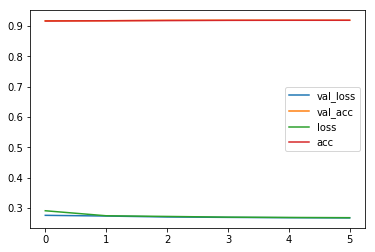

In [12]:
historydf = pd.DataFrame(history.history, index=history.epoch)
historydf.plot();

## Evaluate

In [13]:
from keras.models import load_model

model = load_model('./weights/LSTM.h5')

In [14]:
score, acc = model.evaluate(X_pre_test, y_pre_test)

print('Test score: {}'.format(score))
print('Test accuracy: {} %'.format(acc*100.0))

9754/9754 [==============================] - 8s 816us/step
Test score: 0.2707245235917801
Test accuracy: 91.82044633935166 %


## Output ytest

In [15]:
# Load Xtest
df = pd.read_csv('./data/Xtest.txt', header=None)
df.columns = ['Text']

df.head()

,Text
0,tvletwgzkrqvuhtwamuluhpkskpmpmiwtvuhamqvmviwlr...
1,qvmvuhskleenmvviengzxyuhqvmvamguuhrakrpmsauhul...
2,twamuhulenamuluhskvienuhqgdftwmvmkletwulvimvuh...
3,sooatwqvvitwqvvipmviuhoaampmpmmwuhuhraulvikrpm...
4,lepmuhpmdfuluhtwletwdfuhtwletwamguuhuhraezpmpm...


In [16]:
# Feature Engineering X_test
df['Character vector'] = df['Text'].transform(lambda X: np.array([convert_char_to_num(c) for c in X]))

df.head()

,Text,Character vector
0,tvletwgzkrqvuhtwamuluhpkskpmpmiwtvuhamqvmviwlr...,"[19, 21, 11, 4, 19, 22, 6, 25, 10, 17, 16, 21,..."
1,qvmvuhskleenmvviengzxyuhqvmvamguuhrakrpmsauhul...,"[16, 21, 12, 21, 20, 7, 18, 10, 11, 4, 4, 13, ..."
2,twamuhulenamuluhskvienuhqgdftwmvmkletwulvimvuh...,"[19, 22, 0, 12, 20, 7, 20, 11, 4, 13, 0, 12, 2..."
3,sooatwqvvitwqvvipmviuhoaampmpmmwuhuhraulvikrpm...,"[18, 14, 14, 0, 19, 22, 16, 21, 21, 8, 19, 22,..."
4,lepmuhpmdfuluhtwletwdfuhtwletwamguuhuhraezpmpm...,"[11, 4, 15, 12, 20, 7, 15, 12, 3, 5, 20, 11, 2..."


In [17]:
# Pad X_test
X_test = pad_sequences(np.array(df['Character vector'].values), maxlen=maxlen)

print(X_test.shape)

(3000, 150)


In [18]:
from keras.models import load_model

model = load_model('./weights/LSTM.h5')
y_pred = model.predict(X_test)

In [19]:
y_test = [np.argmax(y, axis=None, out=None) for y in y_pred]

In [20]:
!mkdir -p ./output

with open('./output/ytest.txt', 'w') as outfile:
    for y in y_test:
        outfile.write('{}\n'.format(str(y)))